# Loading packages

In [10]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import cvxpy as cp
import random

# Leader MPC function (simple MPC for tracking a desired velocity)

In [11]:
def MPCL (A,B,D,acc,a_min,a_max,x_0,N,R,Q,l,T,V_0,t_s,u_min,u_max):
    x = cp.Variable((3,N+1))
    u = cp.Variable((N))
    v = cp.Variable((N+1))
    ctrs = [x[:,0]==x_0 , v[0]==V_0]  # initial point
    objective = cp.quad_form(x[:,N]-R,Q)  # terminal cost
    ctrs += [x[2,:]>=a_min , x[2,:]<=a_max] # acceleration limits
    ctrs += [u[:]>=u_min , u[:]<=u_max] # control input limits
    ctrs += [ v[:]<=35 , v[:]>=0 ] # speed limits
    for k in range(N):
        ctrs += [x[:,k+1]==A@x[:,k]+B*u[k]]
        ctrs += [v[k+1]==v[k]+x[2,k]*t_s]
        objective += cp.quad_form(x[:,k]-R,Q)
    objective_cp=cp.Minimize(objective)
    prob = cp.Problem(objective_cp,ctrs)
    prob.solve(verbose=False,solver=cp.GUROBI)
    np.where(v.value[:]<=0.0001,0,x.value[2,:])
    return x.value,v.value

# MPC function for following vehicles (hybrid stochastic MPC)

In [12]:
def SHMPCF(A,B,D,acc,a_min,a_max,x_0,N,R,Q,l,T,V_0,t_s,P_w,P_hat,q_p,i,u_min,u_max,G_w):
    x = cp.Variable((3,N+1))
    u = cp.Variable((N))
    w = cp.Variable((len_w,N),boolean=True)
    v = cp.Variable((N+1))
    g_d = cp.Variable(N+1,boolean=True) # braking mode auxiliary variable
    g_w = cp.Variable(N+1,boolean=True) # warning mode auxiliary variable
    # auxiliary variable used to detect the switching from other modes to braking mode
    h_1 = cp.Variable(N,boolean=True)
    ''' auxiliary variable used to check whether the vehicle's velocity is close to zero
    which is used to avoid vehicle from entering hard braking mode
    (which may generate contradictory constraints) '''
    f_1 = cp.Variable(N+1,boolean=True)
    # auxiliary variable used to represent free following mode (f_1 = 0 ----> normal mode)
    f_2 = cp.Variable(N+1,boolean=True)
    ctrs=[]  
    ctrs += [x[:,0]==x_0 , v[0]==V_0]  # initial conditions
    objective = cp.quad_form(x[:,N]-R,Q)  # terminal cost
    chance_ctr = 0
    ctrs += [x[2,:]>=a_min , x[2,:]<=a_max] # acceleration limits
    ctrs += [u[:]>=u_min , u[:]<=u_max] # control input limits
    ctrs += [v[:]<=35 , v[:]>=0] # speed limits
    for k in range(N+1):
        if k<N:
            # state-space equations with the integration of measurement error:
            ctrs += [x[:,k+1]==A@x[:,k]+acc[k]*D + B*u[k]  + G_w@w[:,k] ]
            # only one measurement error value could be realized at each time step:
            ctrs += [np.ones(len_w)@w[:,k]==1]
            # calculating vehicle velocity:
            ctrs += [v[k+1]==v[k]+x[2,k]*t_s]
            # integration of braking mode into the control input:
            ctrs += [u[k]<=(g_d[k]+f_1[k])/2*(u_min) + (2 - (g_d[k]+f_1[k]))*10]
            ctrs += [g_d[k+1]>=f_2[k]+g_d[k]-1]
            ctrs += [g_d[k+1]<=f_2[k+1]]
            if k>0:
                ctrs += [h_1[k]>=g_d[k+1]-g_d[k] , 1-g_d[k]>=h_1[k] , g_d[k+1]>=h_1[k]]
            chance_ctr += w[:,k]@P_w 
            chance_ctr += np.log(0.9)*h_1[k]
        #%%%%%%%%%%%%%%%%%%%%%%% warning and braking modes constraints
        ctrs += [x[0,k]>=5.0001-v[k]*T]
        ctrs += [v[k]-(3*abs(a_min)*t_s)<=100*f_1[k] , v[k]-(3*abs(a_min)*t_s)>= (1-f_1[k])*(-100)]
        ctrs += [x[1,k] + 2<=30*(1-f_2[k]) , x[1,k] + 2>=f_2[k]*(-30)]
        ctrs += [g_w[k]+g_d[k]==f_2[k] ]
        chance_ctr += np.log(1-0.9)*g_w[k]
        ####################################
        objective += cp.quad_form(x[:,k]-R,Q) + 3*cp.square(x[0,k]-l-(0.01*V_0)*t_s*f_2[k]) \
                                            + 3*cp.square(x[1,k]-(0.01*V_0)*f_2[k])
    ctrs += [chance_ctr>=P_hat]
    objective += -q_p*chance_ctr
    objective_cp=cp.Minimize(objective)
    prob = cp.Problem(objective_cp,ctrs)
    prob.solve(verbose=False)
    return x.value,v.value,f_2.value[0],u.value[0]

## Main

In [13]:
V_N = 5 # number of vehicles
T_F = 200 # simulation steps
t_s = 0.1 # sampling time
N = 7  # prediction horizon
T = 0.7 # time headway gap
l_v = 5 # vehicle_length
f = 0.1 # driveline dynamics
l = 2+l_v
# acceleration limits
a_min = -4
a_max = 3
# control input limits
u_min = -4
u_max = 4
# state space matrices
A = np.array([ [1 ,t_s,-T*t_s] , [0, 1 ,-t_s] , [0,0,1-t_s/f] ])
B = np.array([0 , 0 , t_s/f])
D = np.array([0 , t_s , 0])
####### uncontrollable event variables
P_hat = 0.005**N 
q_p = 0.4
r_0 = 0.25
r_0 = 0.25
len_w = int(r_0/0.05)*2+1
M_w = np.arange(-int(r_0/0.05), int(r_0/0.05)+1)*0.05
xU, xL = M_w + 0.025, M_w - 0.025
prob = ss.norm.cdf(xU, scale = r_0/3) - ss.norm.cdf(xL, scale = r_0/3)
P_w = prob / prob.sum() #normalize the probabilities so their sum is 1
AP_w = np.ones((P_w.size))
AP_w[0]=P_w[0]
for j in range(1,P_w.size):
    AP_w[j]= AP_w[j-1]+P_w[j]
G_w = np.zeros((3,np.size(P_w)))
G_w[0,:] = M_w

q_t = np.zeros((V_N,T_F+1)) # location
v_t = np.zeros((V_N,T_F+1)) # velocity
a_t = np.zeros((V_N,T_F+1)) # acceleration
dd_t = np.zeros((V_N,T_F+1)) # dd_t[i,t+1] = q_t[i-1,t+1] - q_t[i,t+1] - T*v_t[i,t+1]
x_0 = np.zeros((V_N,3)) # initial condition for the MPC function
acc = np.zeros((N+1))
a = np.zeros((V_N,N))
a_current = np.zeros((V_N,N))
d_e = np.zeros((V_N,T_F+1))
####### initial values
q_t[:,0] = 20*np.arange(V_N,0,-1)
v_t[:,0] = 15*np.ones(V_N)
a_t[:,0] = np.zeros(V_N)
u_t = np.zeros((V_N,T_F+1))

for j in range(1,V_N):
    dd_t[j,0]= q_t[j-1,0]-q_t[j,0]- T*v_t[j,0]  ## dd_t[0,:] is meaningless

for t in range(T_F):
    a = a_current
    for i in range (V_N):
        ###################################################################
        if i==0: # leader vehicle
            acc = np.zeros((N+1))
            A = np.array([ [0,0,0] , [0, 1 ,t_s] , [0,0,1-t_s/f] ])
            V_max = 20
            V_min = -20
            Q = np.array([ [0,0,0] , [0,5,0] , [0,0,1] ])
            w_0 = np.zeros(3)
            # speed reference for the leader vehicle
            R = np.array([0,29,0])   
            x_0 = np.array([q_t[0,t],v_t[0,t],a_t[0,t]])
            O = MPCL (A,B,D,acc,a_min,a_max,x_0,N,R,Q,l,T,v_t[i,t],t_s,u_min,u_max)
        ####################################################################        
        else: # follower vehicles
            A = np.array([ [1 ,t_s,-T*t_s] , [0, 1 ,-t_s] , [0,0,1-t_s/f] ])
            acc = a[i-1,:]
            R = np.array([l,0,0])
            V_min = -20
            V_max = 20
            Q = np.array([ [0,0,0] , [0,0,0] , [0,0,0.35] ])
            ####### uncontrolleable event variables
            r = random.random()
            w_0 = np.zeros(np.size(P_w))
            w_0[np.where(r<=AP_w)[0][0]] = 1
            x_0 = np.array([dd_t[i,t]+M_w@w_0,v_t[i-1,t]-v_t[i,t],a_t[i,t]])
            O = SHMPCF (A,B,D,acc,a_min,a_max,x_0,N,R,Q,l,T,v_t[i,t],t_s,np.log(P_w),
                        np.log(P_hat),q_p,i,u_min,u_max,G_w)
        ###########################################################################
        v_t[i,t+1] = O[1][1]
        if v_t[i,t+1]<0:
            v_t[i,t+1]=0
        a_t[i,t+1] = O[0][2,1]
        q_t[i,t+1] = q_t[i,t] + t_s*v_t[i,t]
        if i>0:
            u_t[i,t+1] = O[-1]
        a_current[i,:] = O[0][2,1:] 
        if i==0:
            dd_t[i,t+1] = O[0][0,1]
        else:
            dd_t[i,t+1] = q_t[i-1,t+1] - q_t[i,t+1] - T*v_t[i,t+1]
            d_e[i,t] = O[2]

# PLOT

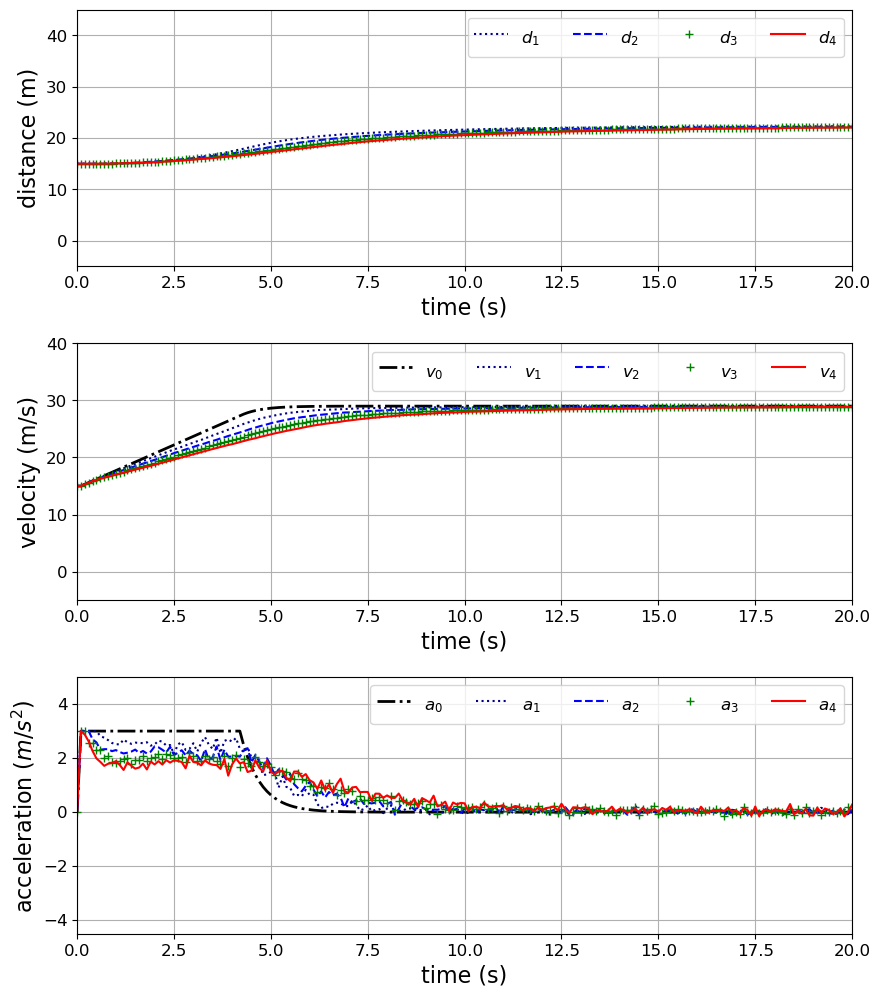

In [14]:
size_1 = 16
size_2 = 10
size_3 = 12
plt.rc('font', size=size_2)          
plt.rc('axes', titlesize=size_3) 
plt.rc('axes', labelsize=size_1)
plt.rc('xtick', labelsize=size_3)
plt.rc('ytick', labelsize=size_3)
plt.rc('legend', fontsize=size_3)
plt.rc('figure', titlesize=size_2)
markers = [':', '--' , '+','-','*','3-','x','|-','-.']
color1 = ['darkblue','b' , 'g' , 'r' , 'tab:orange' , 'deepskyblue' ,\
          'tab:orange' ,'tab:purple' , 'darkred','mediumaquamarine']
x1 = []
for j in range(T_F+1):
    x1.append(j*t_s)
fig, axs = plt.subplots(3,gridspec_kw={'height_ratios': [1, 1,1]})
fig.set_size_inches(10, 12)

counter12 = 0
for i in range(V_N-1):
    s='$d_{%i}$' % (i+1)
    axs[0].plot(x1,q_t[i,:]-q_t[i+1,:]-l_v,markers[counter12],c=color1[counter12],label=s)  
    counter12 += 1
    if counter12>8:
        counter12 = 0
axs[0].set(xlabel='time (s)', ylabel='distance (m)')    
axs[0].set_xlim(x1[0],x1[-1])
axs[0].set_ylim(-5,45)
axs[0].grid()
axs[0].legend(ncol=9,handleheight=2,loc='upper right')

counter12 = 0
axs[1].plot(x1,v_t[0,:],'k-.',linewidth=2,label='$v_{0}$')
for i in range(1,V_N):
    s='$v_{%i}$' % (i)
    axs[1].plot(x1,v_t[i,:],markers[counter12],c=color1[counter12],label=s)   
    counter12 += 1
    if counter12>8:
        counter12 = 0
axs[1].set(xlabel='time (s)', ylabel='velocity (m/s)')    
axs[1].set_xlim(x1[0],x1[-1])
axs[1].set_ylim(-5,40)
axs[1].grid()
axs[1].legend(ncol=10,handleheight=2,loc='upper right') 

axs[2].plot(x1,a_t[0,:],'k-.',linewidth=2,label='$a_{0}$')
counter12 = 0
for i in range(1,V_N):
    s='$a_{%i}$'%(i)
    axs[2].plot(x1,a_t[i,:],markers[counter12],c=color1[counter12],label=s)   
    counter12 += 1
    if counter12>8:
        counter12 = 0
axs[2].set(xlabel='time (s)', ylabel='acceleration $(m/s^{2})$')    
axs[2].set_xlim(x1[0],x1[-1])
axs[2].set_ylim(-4.5,5)
axs[2].grid()
axs[2].legend(ncol=V_N,handleheight=2,loc='upper right') 
plt.subplots_adjust(hspace=0.3)